# CIBMTR - Equity in post - HCT Survival Predictions
This notebook is intended as our main source for working on the kaggle competition [CIBMTR - Equity in post - HCT Survival Predictions](https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/team )

This is for UofMDearbornTeam1's submission.

## Introduction

This is where we can all collectively work on different portions of the code to be broken off into separate files, notebooks or python scripts if needed. Otherwise we will contain it in a single python notebook hosted here on google colab.


Make your code as self describing as possible. Where needed, add a text description like the one here or in the code itself using comments. Using '#', '##', '###', etc to notate different sections is much appreciated.

If you've never used collab/notebooks/jupyter before or you just forgot how to add text or code blocks just float your mouse to the top or bottom center of an existing block of text or code. You'll then be able to add a new text box or a code block with just a click. You can also do it using the insert menu in the toolbar or just below it, by default it is a hotkey in the toolbar.

A great place to start finding what we need to do is to look here:
https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/549968

You can see other people's submission here:
https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/leaderboard

A guide on getting started with kaggle API's can be found here:

https://www.kaggle.com/competitions/rsna-2024-lumbar-spine-degenerative-classification/code

The github page for kaggle api is here:

https://github.com/Kaggle/kagglehub?tab=readme-ov-file#authenticate

## Prequisite Installs and Imports
A set of scripts that might need to be ran before your environment will run properly. This has been written with collab in mind and might not be needed. If you regularly have to install certain libraries please initiate a pull request with CIBMTR/Kaggle to modify the competition as they do not include internet access for the analysis section of the competition - this begins after the competition is over. Any additional libraries that you need installed have to be added by them in order to properly run.

Start by adding your library to the import page, if it natively runs you may not need an install. If it does not or if you get outdated errors, consider adding it to the install section.

### Installs

In [1]:
#%pip install kagglehub
#%pip install kaggle

### Imports

In [2]:
import kagglehub, shutil, pandas as pd
from google.colab import userdata, drive, files


## Data
The following code blocks are dedicated to data loading, cleaning and normalization


### Data Loading
Use this code to load the data using the API.

#### Load the data into a pandas dataframe
Now that we have the data let's get it loaded into panda so we can look at it.

In [3]:
#Data Load
import pandas as pd
dfDataDict = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')
dfSample = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')
dfTest = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
dfTrain = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')

### Data Cleaning
This is the code block where we will clean the data. Here we may have to remove bad data, change formats, check for errors, separate different forms of data etc

#### Data Dictionary

In [4]:
#Data Cleaning
## First let's show the samples of each file:
#dfDataDict

### Modify Data Dictionary

#### Test Data

In [5]:
#dfTest

#### Train Data

In [6]:
#dfTrain

#### Sample Submission

In [7]:
#dfSample

### Data Normalization
Often when we load data into a NN we will have to normalize the data to some extent. In raw data this might mean changing the categorical values to numeric or setting the mean to 0 and applying a standard deviation to the data.

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch


# Define columns
categorical_columns = dfTrain.select_dtypes(include=['object']).columns.tolist()
numerical_columns = dfTrain.select_dtypes(exclude=['object']).columns.tolist()

# Remove ID and target columns from features
columns_to_remove = ['ID','efs', 'efs_time']
for col in columns_to_remove:
    if col in numerical_columns:
        numerical_columns.remove(col)

# Define target column (focusing on efs_time prediction)
target_column = 'efs_time'

def convert_to_string(df, columns):
    """Convert specified columns to string type"""
    df = df.copy()
    for col in columns:
        df[col] = df[col].astype(str)
    return df

def no_nulls(df, numerical, categorical):
    """Fill null values in the dataframe"""
    df = df.copy()
    for column in categorical:
        df[column] = df[column].fillna('Unknown')
    for column in numerical:
        df[column] = df[column].fillna(df[numerical].mean()[column])
    return df

def preprocess_data(df, numerical_columns, categorical_columns, scaler=None, encoder=None, fit=False):
    """
    Preprocess the data with option to fit or use existing transformers
    """
    df = df.copy()

    # Convert categorical columns to string type
    df = convert_to_string(df, categorical_columns)

    # Fill missing values
    df = no_nulls(df, numerical_columns, categorical_columns)

    # Scale numerical features
    if numerical_columns:
        if scaler is None and fit:
            scaler = MinMaxScaler()
            scaled_features = scaler.fit_transform(df[numerical_columns])
        elif scaler is not None:
            scaled_features = scaler.transform(df[numerical_columns])

        df[numerical_columns] = scaled_features

    # Encode categorical features
    if categorical_columns:
        if encoder is None and fit:
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoded_features = encoder.fit_transform(df[categorical_columns])
        elif encoder is not None:
            encoded_features = encoder.transform(df[categorical_columns])

        encoded_df = pd.DataFrame(
            encoded_features,
            columns=encoder.get_feature_names_out(categorical_columns),
            index=df.index
        )

        # Drop original categorical columns and join encoded features
        df = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

    return df, scaler, encoder

# Split the data
X = dfTrain.drop(columns=[target_column, 'efs'])
y = dfTrain[target_column]

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocess training data
X_train, scaler, encoder = preprocess_data(
    X_train_raw,
    numerical_columns,
    categorical_columns,
    fit=True
)

# Preprocess validation data
X_val, _, _ = preprocess_data(
    X_val_raw,
    numerical_columns,
    categorical_columns,
    scaler=scaler,
    encoder=encoder
)

# Preprocess test data
X_test, _, _ = preprocess_data(
    dfTest,
    numerical_columns,
    categorical_columns,
    scaler=scaler,
    encoder=encoder,
    fit=True
)


#### Build Tensors

In [9]:
import torch
import numpy as np

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

## Model
Here we train and test the model

### Model Definition

In [10]:
import torch.nn as nn

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Initialize model and training parameters
input_size = X_train.shape[1]
hidden_size = 56
output_size = 1

In [11]:
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

In [12]:
# Training loop
num_epochs = 500
best_val_loss = float('inf')
patience = 500
patience_counter = 0

print("Starting training...")
print(f"Training data shape: {X_train_tensor.shape}")
print(f"Validation data shape: {X_val_tensor.shape}")

for epoch in range(num_epochs):
    # Training
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {loss.item():.4f}')
        print(f'Validation Loss: {val_loss.item():.4f}')

Starting training...
Training data shape: torch.Size([23040, 214])
Validation data shape: torch.Size([5760, 214])
Epoch [10/500]
Training Loss: 185187.9531
Validation Loss: 1383.9014
Epoch [20/500]
Training Loss: 119305.2109
Validation Loss: 1079.3313
Epoch [30/500]
Training Loss: 79638.1094
Validation Loss: 912.1865
Epoch [40/500]
Training Loss: 56808.5039
Validation Loss: 824.8175
Epoch [50/500]
Training Loss: 40792.4727
Validation Loss: 779.9036
Epoch [60/500]
Training Loss: 31343.8496
Validation Loss: 772.3939
Epoch [70/500]
Training Loss: 24389.6582
Validation Loss: 759.9585
Epoch [80/500]
Training Loss: 19057.4531
Validation Loss: 751.3249
Epoch [90/500]
Training Loss: 14985.7461
Validation Loss: 746.2307
Epoch [100/500]
Training Loss: 12182.9463
Validation Loss: 748.9122
Epoch [110/500]
Training Loss: 10138.4629
Validation Loss: 746.8448
Epoch [120/500]
Training Loss: 8219.0684
Validation Loss: 747.2412
Epoch [130/500]
Training Loss: 6824.5430
Validation Loss: 747.8533
Epoch [14

In [13]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

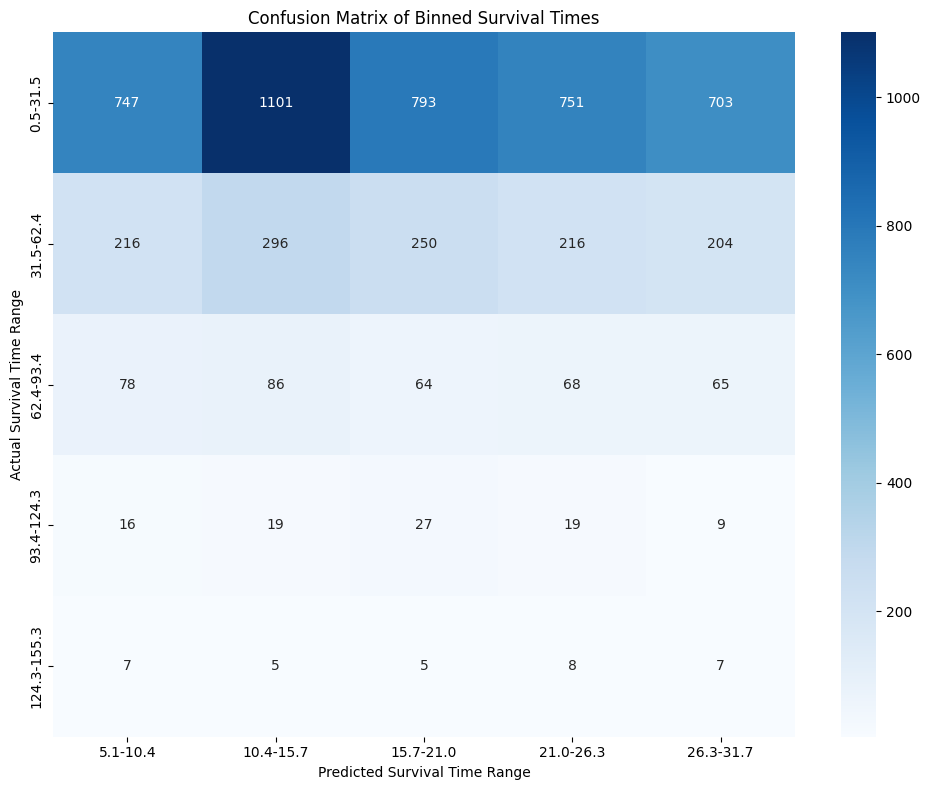

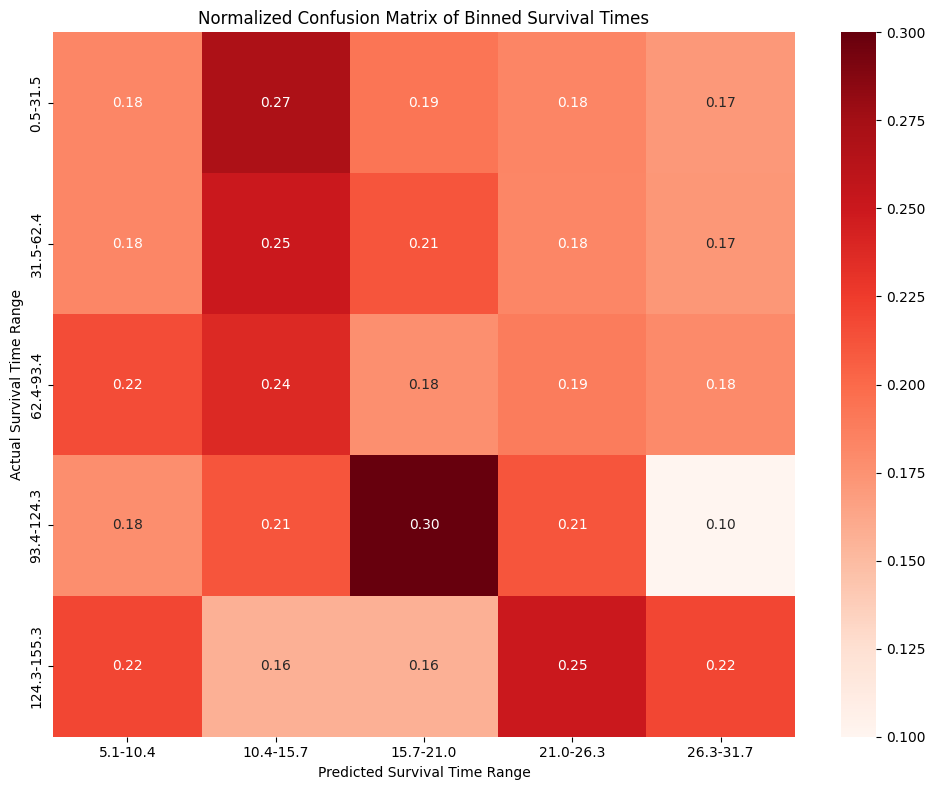

Mean Squared Error: 709.2039
Root Mean Squared Error: 26.6309
Mean Absolute Error: 18.9604
R² Score: -0.1379


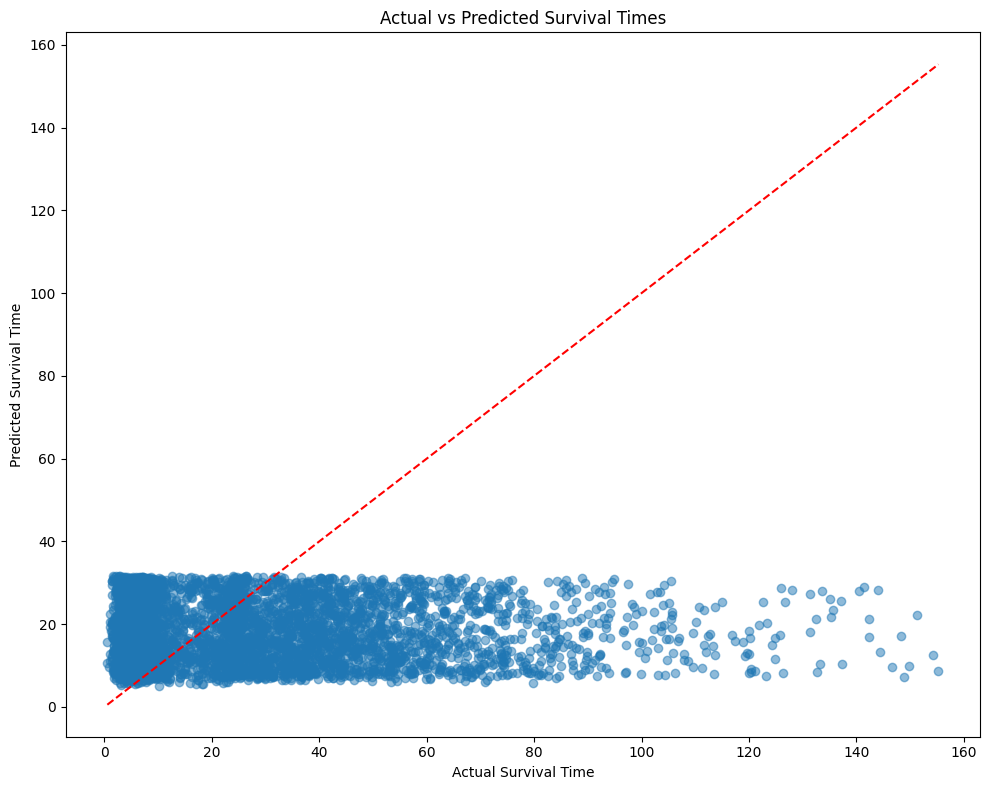

In [14]:
# Code for creating a confusion matrix visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# To create a confusion matrix for regression results, we'll bin the values
def bin_values(values, num_bins=5):
    """Bin continuous values into discrete categories"""
    # Create bins based on equal width
    bins = np.linspace(min(values), max(values), num_bins + 1)
    # Assign each value to a bin
    binned = np.digitize(values, bins[1:-1])
    return binned, bins

# For demonstration, let's use validation data for the confusion matrix
with torch.no_grad():
    val_predictions = model(X_val_tensor).numpy().flatten()

# Get actual values
val_actuals = y_val.values

# Bin both predictions and actuals
num_bins = 5  # You can adjust this value
binned_preds, pred_bins = bin_values(val_predictions, num_bins)
binned_actuals, actual_bins = bin_values(val_actuals, num_bins)

# Create confusion matrix
cm = confusion_matrix(binned_actuals, binned_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"{pred_bins[i]:.1f}-{pred_bins[i+1]:.1f}" for i in range(len(pred_bins)-1)],
            yticklabels=[f"{actual_bins[i]:.1f}-{actual_bins[i+1]:.1f}" for i in range(len(actual_bins)-1)])
plt.xlabel('Predicted Survival Time Range')
plt.ylabel('Actual Survival Time Range')
plt.title('Confusion Matrix of Binned Survival Times')
plt.tight_layout()
plt.savefig('survival_confusion_matrix.png')
plt.show()

# Add a more detailed analysis - normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=[f"{pred_bins[i]:.1f}-{pred_bins[i+1]:.1f}" for i in range(len(pred_bins)-1)],
            yticklabels=[f"{actual_bins[i]:.1f}-{actual_bins[i+1]:.1f}" for i in range(len(actual_bins)-1)])
plt.xlabel('Predicted Survival Time Range')
plt.ylabel('Actual Survival Time Range')
plt.title('Normalized Confusion Matrix of Binned Survival Times')
plt.tight_layout()
plt.savefig('survival_confusion_matrix_normalized.png')
plt.show()

# Add additional evaluation metrics for the regression model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(val_actuals, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_actuals, val_predictions)
r2 = r2_score(val_actuals, val_predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 8))
plt.scatter(val_actuals, val_predictions, alpha=0.5)
plt.plot([min(val_actuals), max(val_actuals)], [min(val_actuals), max(val_actuals)], 'r--')
plt.xlabel('Actual Survival Time')
plt.ylabel('Predicted Survival Time')
plt.title('Actual vs Predicted Survival Times')
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

In [15]:
# Generate predictions for the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)

# Convert to Numpy for proper output
test_outputs = test_outputs.numpy().flatten().tolist()

# Convert predictions to a DataFrame
submission = pd.DataFrame({
    'ID': dfTest['ID'],  # Assuming 'ID' is the identifier column
    #'efs': test_outputs[:, 0],  # Predicted efs
    'prediction': test_outputs  # Predicted efs_time
})



In [16]:
print(submission)
submission['prediction'] = submission['prediction'].fillna(submission['prediction'].mean())

      ID  prediction
0  28800   31.899597
1  28801   31.485643
2  28802   31.879156


In [17]:
# Save to CSV
submission.to_csv('submission.csv', index=False)